In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    torch.cuda.empty_cache()
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on GPU


In [ ]:
!unzip -q /content/gdrive/MyDrive/DATASET.zip

In [ ]:
DATA_PATH = '/content/DATASET/TRAIN'

In [ ]:
class_names = os.listdir(DATA_PATH)
image_count = {}
print("TRAIN DATASET")
print("-"*20)
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))
    print(i,"IMAGE:",image_count[i])

TRAIN DATASET
--------------------
NORMAL IMAGE: 10192
COVID IMAGE: 3616
PNEUMONIA IMAGE: 1345


In [ ]:
Size=(224, 224)
Mean=[0.485, 0.456, 0.406]
Std=[0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize(Size), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(Mean,Std)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize(Size),
                                transforms.ToTensor(),
                                transforms.Normalize(Mean,Std)
                    ])}

In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,transform=data_transforms['train'])
    test_data = datasets.ImageFolder(datadir,transform=data_transforms['val'])

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler, batch_size=32) 
    testloader = torch.utils.data.DataLoader(test_data,sampler=test_sampler, batch_size=32)
    return trainloader, testloader, dataset_size

In [ ]:
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
for i,k in data_sizes.items():
  print(i,"set:",k,"images")

train set: 12123 images
val set: 3030 images


In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10,final=False):

    # if final==false, it means the model is being tested (eg. learning rate loop). The best result is not recorded. 

    since = time.time()
    if final:
      best_model_wts = copy.deepcopy(model.state_dict())
      best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()

            current_loss = 0.0
            current_corrects = 0

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data) 
  
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects / data_sizes[phase]
            print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))
            if phase == 'val':
                valid_accu.append(epoch_acc)
                valid_losses.append(epoch_loss)
            else:
                train_accu.append(epoch_acc)
                train_losses.append(epoch_loss)

            if final and phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    
    if final:
      print('Best val loss: {:.4f}'.format(best_loss))
      model.load_state_dict(best_model_wts)

    return model

In [ ]:
model = torchvision.models.resnext101_32x8d(pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=3)
model.to(device)
torch.save(model.state_dict(), "/content/starting_point")
criterion = nn.CrossEntropyLoss() 

In [ ]:
 def draw(): 

  plt.plot(range(1, len(train_accu) + 1), train_accu,'-o')
  plt.plot(range(1, len(valid_accu) + 1), valid_accu,'-o')
  #plt.axvline(x=5,c='r')
  #plt.axvline(x=10,c='r')
  #plt.axvline(x=15,c='r')
  #plt.axvline(x=20,c='r')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Accuracy')
  
  plt.show()
  plt.plot(range(1, len(train_losses) + 1), train_losses,'-o')
  plt.plot(range(1, len(valid_losses) + 1), valid_losses,'-o')
  #plt.axvline(x=5,c='r')
  #plt.axvline(x=10,c='r')
  #plt.axvline(x=15,c='r')
  #plt.axvline(x=20,c='r')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Loss')
  plt.show()

In [ ]:
train_losses=[]
train_accu=[]
valid_losses=[]
valid_accu=[]

model.load_state_dict(torch.load("/content/starting_point"))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
base_model = train_model(model, criterion, optimizer, num_epochs=20,final=True)

Epoch 1/20
----------


train Loss: 0.1950 | train Accuracy: 0.9332


val Loss: 0.0680 | val Accuracy: 0.9776
Val loss Decreased from inf to 0.0680 
Saving Weights... 

Epoch 2/20
----------


train Loss: 0.0556 | train Accuracy: 0.9833


val Loss: 0.0348 | val Accuracy: 0.9884
Val loss Decreased from 0.0680 to 0.0348 
Saving Weights... 

Epoch 3/20
----------


train Loss: 0.0415 | train Accuracy: 0.9859


val Loss: 0.0354 | val Accuracy: 0.9898

Epoch 4/20
----------


train Loss: 0.0289 | train Accuracy: 0.9910


val Loss: 0.0265 | val Accuracy: 0.9908
Val loss Decreased from 0.0348 to 0.0265 
Saving Weights... 

Epoch 5/20
----------


train Loss: 0.0245 | train Accuracy: 0.9925


val Loss: 0.0419 | val Accuracy: 0.9848

Epoch 6/20
----------


train Loss: 0.0192 | train Accuracy: 0.9948


val Loss: 0.0264 | val Accuracy: 0.9904
Val loss Decreased from 0.0265 to 0.0264 
Saving Weights... 

Epoch 7/20
----------


train Loss: 0.0148 | train Accuracy: 0.9951


val Loss: 0.0224 | val Accuracy: 0.9921
Val loss Decreased from 0.0264 to 0.0224 
Saving Weights... 

Epoch 8/20
----------


train Loss: 0.0169 | train Accuracy: 0.9954


val Loss: 0.0189 | val Accuracy: 0.9934
Val loss Decreased from 0.0224 to 0.0189 
Saving Weights... 

Epoch 9/20
----------


train Loss: 0.0116 | train Accuracy: 0.9963


val Loss: 0.0219 | val Accuracy: 0.9934

Epoch 10/20
----------


train Loss: 0.0115 | train Accuracy: 0.9969


val Loss: 0.0209 | val Accuracy: 0.9931

Epoch 11/20
----------


train Loss: 0.0109 | train Accuracy: 0.9965


val Loss: 0.0211 | val Accuracy: 0.9934

Epoch 12/20
----------


train Loss: 0.0095 | train Accuracy: 0.9973


val Loss: 0.0208 | val Accuracy: 0.9941

Epoch 13/20
----------


train Loss: 0.0092 | train Accuracy: 0.9971


val Loss: 0.0258 | val Accuracy: 0.9927

Epoch 14/20
----------


train Loss: 0.0062 | train Accuracy: 0.9979


val Loss: 0.0230 | val Accuracy: 0.9937

Epoch 15/20
----------


train Loss: 0.0108 | train Accuracy: 0.9968


val Loss: 0.0147 | val Accuracy: 0.9950
Val loss Decreased from 0.0189 to 0.0147 
Saving Weights... 

Epoch 16/20
----------


train Loss: 0.0052 | train Accuracy: 0.9981


val Loss: 0.0160 | val Accuracy: 0.9960

Epoch 17/20
----------


train Loss: 0.0088 | train Accuracy: 0.9973


val Loss: 0.0186 | val Accuracy: 0.9947

Epoch 18/20
----------


train Loss: 0.0038 | train Accuracy: 0.9993


val Loss: 0.0238 | val Accuracy: 0.9927

Epoch 19/20
----------


train Loss: 0.0044 | train Accuracy: 0.9987


val Loss: 0.0212 | val Accuracy: 0.9950

Epoch 20/20
----------


train Loss: 0.0079 | train Accuracy: 0.9976


val Loss: 0.0259 | val Accuracy: 0.9914

Training complete in 139m 25s
Best val loss: 0.0147


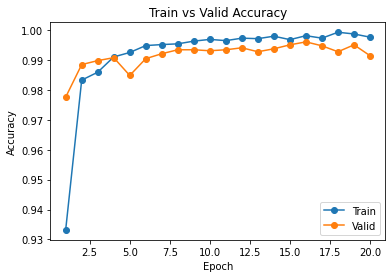

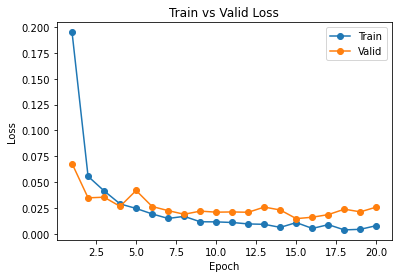

In [ ]:
draw()

# TESTING

In [ ]:
TEST_DATA_PATH = '/content/DATASET/TEST/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(Mean,Std)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88       576
           1       0.85      0.95      0.90      1583
           2       0.98      0.96      0.97      4273

    accuracy                           0.94      6432
   macro avg       0.93      0.91      0.92      6432
weighted avg       0.95      0.94      0.94      6432



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\nTest accuracy={:0.4f}'.format(accuracy))
    plt.show()

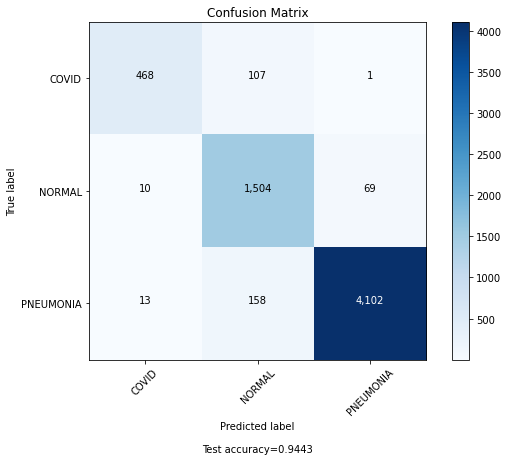

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ["COVID","NORMAL","PNEUMONIA"],
                      title        = "Confusion Matrix")

In [ ]:
torch.save(base_model.state_dict(), './best_model.pth')